# Racetrack

This notebook covers Exercise 5.4 of http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf .

Here, we control a race car on a track for a right turn. Positions and velocities are all discrete, and actions are increments to horizontal and vertical velocity components (-1, 0, 1). The maximum velocity for each component is 4, both velocities should be nonnegative, and they cannot be zero simultaneously. The reward is -1 for every on-track movement, and -10 for off-track movement. Whenever the car goes out of track, it is projected back to the track. I did not implement the proper collision check, however, so the car can "pass through the wall" during an action.

We approach this problem with two algorithms: 1) On-policy Monte Carlo Control, and 2) SARSA.

## On-Policy Monte-Carlo Control

We first approach this problem with an $\epsilon$-soft on-policy Monte Carlo control algorithm (Figure 5.6), as suggested by the book. Probably the algorithm is very naive, but seems to work OK for a simple problem like this.

In [1]:
# imports
import math
import itertools
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline  

In [2]:
random.seed(135135)

In [3]:
trackstr1 = """
000000000000000000
000011111111111112
000111111111111112
000111111111111112
001111111111111112
011111111111111112
011111111111111112
011111111110000000
011111111100000000
011111111100000000
011111111100000000
011111111100000000
011111111100000000
011111111100000000
011111111100000000
001111111100000000
001111111100000000
001111111100000000
001111111100000000
001111111100000000
001111111100000000
001111111100000000
001111111100000000
000111111100000000
000111111100000000
000111111100000000
000111111100000000
000111111100000000
000111111100000000
000111111100000000
000011111100000000
000011111100000000
000033333300000000
000000000000000000
"""

In [4]:
def trackstr_to_array(trackstr):
    line_array_list = []
    for line_num, line in enumerate(trackstr.split("\n")):
        if line_num == 0:
            continue
        line_array = [int(valstr) for valstr in line]
        if len(line_array) > 0:
            line_array_list.append(line_array)
    return np.array(list(reversed(line_array_list)))

trackdata1 = trackstr_to_array(trackstr1)

In [5]:
trackdata1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [6]:
def draw_track(trackdata):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, aspect='equal')
    color_code = ["black", "white", "red", "blue"]
    for i in range(trackdata.shape[0]):
        for j in range(trackdata.shape[1]):
            ax.add_patch(patches.Rectangle((j * 1.0, i * 1.0), 1.0, 1.0, facecolor=color_code[trackdata[i,j]]))        
    plt.xlim(0, trackdata.shape[1])
    plt.ylim(0, trackdata.shape[0])
    return ax

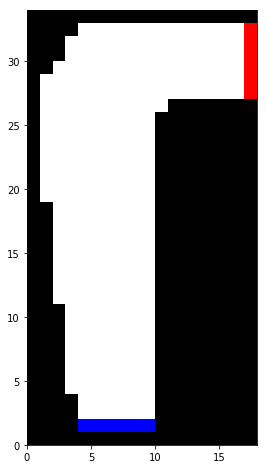

In [7]:
draw_track(trackdata1)

In [8]:
np.where(trackdata1 == 3)

(array([1, 1, 1, 1, 1, 1]), array([4, 5, 6, 7, 8, 9]))

In [9]:
class RaceTrack(object):
    
    def __init__(self, trackdata):
        self.trackdata = trackdata
        self.start_ys, self.start_xs = np.where(trackdata == 3)
        self.end_ys, self.end_xs = np.where(trackdata == 2)
    
    def actions(self, state):
        """returns eligible set of actions"""
        pos_x, pos_y, vel_x, vel_y = state
        ret = []
        for acc_x, acc_y in itertools.product(list(range(-1, 2)), list(range(-1, 2))):
            # velocity cannot be negative
            if (vel_x + acc_x < 0) or (vel_y + acc_y < 0):
                continue
            # velocity should be less than 5
            if (vel_x + acc_x >= 5) or (vel_y + acc_y >= 5):
                continue
            # both velocities cannot be zero
            if (vel_x + acc_x == 0) and (vel_y + acc_y == 0):
                continue
            ret.append((acc_x, acc_y))
        return ret
    
    def is_terminal(self, state):
        """returns True if the episode has ended"""
        pos_x, pos_y, vel_x, vel_y = state
        
        flag_x = False
        flag_y = False        
        for end_x in self.end_xs:
            if pos_x >= end_x:
                flag_x = True
                break
        for end_y in self.end_ys:
            if pos_y == end_y:
                flag_y = True
                break
        
        return flag_x and flag_y
    
    def is_on_track(self, state):
        """returns whether the state is on track"""
        pos_x, pos_y, vel_x, vel_y = state
        if pos_x < 0 or pos_y < 0:
            return False
        if pos_x >= self.trackdata.shape[1]:
            return False
        if pos_y >= self.trackdata.shape[0]:
            return False
        if self.trackdata[pos_y, pos_x] <= 0:
            return False
        return True
    
    def project_state(self, prev_state, new_state):
        prev_x, prev_y, _, _ = prev_state
        new_x, new_y, vel_x, vel_y = new_state
        min_dist = float('inf')
        cand_x, cand_y = -1, -1
        for x in range(prev_x, new_x + 1):
            for y in range(prev_y, new_y + 1):
                if not self.is_on_track((x, y, vel_x, vel_y)):
                    continue
                dist = abs(new_x - x) + abs(new_y - y)
                if dist < min_dist:
                    cand_x = x
                    cand_y = y
                    min_dist = dist
        assert (cand_x != -1) and (cand_y != -1)
        return cand_x, cand_y, vel_x, vel_y
    
    def next(self, state, action):
        """Given the state and the new action, return the triple: 
        (new state, reward, flag indicating whether the episode ends)
        """
        pos_x, pos_y, vel_x, vel_y = state
        acc_x, acc_y = action
        vel_x += acc_x
        vel_y += acc_y
        
        pos_x += vel_x
        pos_y += vel_y
        
        new_state = (pos_x, pos_y, vel_x, vel_y)
        # check whether the goal has been reached
        flag_terminal = self.is_terminal(new_state)
        if flag_terminal or self.is_on_track(new_state):
            reward = -1
        else:            
            # if the goal has not been reached, project the state
            new_state = self.project_state(state, new_state)
            # check whether the goal has been reached in the projected state
            flag_terminal = self.is_terminal(new_state)
            reward = -10
                
        # make sure the position is always advanced
        if (not flag_terminal) and (state[0:2] == new_state[0:2]):
            pos_x, pos_y, vel_x, vel_y = new_state
            cand_state = (pos_x + 1, pos_y, vel_x, vel_y)
            if self.is_on_track(cand_state):
                new_state = cand_state
            else:
                cand_state = (pos_x, pos_y + 1, vel_x, vel_y)
                if self.is_on_track(cand_state):
                    new_state = cand_state
                else:
                    raise Exception('unable to proceed the position from: {}'.format(new_state))
                
        return new_state, reward, flag_terminal
    
    def play(self, start_state, policy, verbose=False):
        state = start_state
        total_reward = 0
        state_action_rewards = []
        if verbose:
            print('start_state: {}'.format(start_state))
        while True:
            action = policy(state, self.actions(state))
            if verbose:
                print('action: {}'.format(action))            
            new_state, reward, is_terminal = self.next(state, action)
            state_action_rewards.append((state, action, reward))
            total_reward += reward
            if verbose:
                print('new_state: {}, reward: {}, is_terminal: {}'.format(new_state, reward, is_terminal))
            if is_terminal:
                state_action_rewards.append((new_state, None, 0))
                break
            state = new_state
        if verbose:
            print('total reward: {}'.format(total_reward))
        return state_action_rewards, total_reward

In [10]:
class OnPolicyMonteCarloControl(object):
    
    def __init__(self, epsilon=0.1):
        self.state_action_counts = defaultdict(int)
        self.state_action_values = defaultdict(float)
        self.epsilon = epsilon
    
    def get_policy(self):
        def policy(state, action_set):
            if random.random() < self.epsilon:
                return random.choice(action_set)
            else:
                # find greedy action
                cand_action = None
                cand_value = float('-inf')                
                for action in action_set:
                    value = self.state_action_values[(state, action)]
                    if value > cand_value:
                        cand_action = action
                        cand_value = value
                return cand_action  
        return policy
    
    def learn(self, start_state, environment, episode_num=10, episode_end_callback=None):
        policy = self.get_policy()
        total_reward_list = []
        for episode_iter in range(episode_num):
            state_action_rewards, total_reward = environment.play(start_state, policy)
            for state, action, reward in state_action_rewards:
                self.state_action_counts[(state, action)] += 1
                self.state_action_values[(state, action)] += ((total_reward - 
                                                               self.state_action_values[(state, action)])/
                                                               self.state_action_counts[(state, action)])
            total_reward_list.append(total_reward)
            if episode_end_callback is not None:
                episode_end_callback(environment, state_action_rewards, episode_iter, total_reward)
        # return the last episode
        return state_action_rewards, total_reward_list

In [11]:
def draw_path(track, state_action_rewards, title=None):
    ax = draw_track(track.trackdata)
    for idx in range(len(state_action_rewards) - 1):
        prev_x, prev_y = state_action_rewards[idx][0][0:2]
        new_x, new_y = state_action_rewards[idx + 1][0][0:2]
        ax.arrow(prev_x + 0.5, prev_y + 0.5, new_x - prev_x, new_y - prev_y, 
                 head_width=0.5, head_length=0.5, fc='pink', ec='pink')
    if title is not None:
        ax.set_title(title)

In [12]:
track1 = RaceTrack(trackdata1)
mccontrol1 = OnPolicyMonteCarloControl()

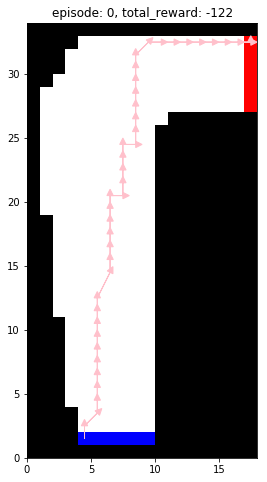

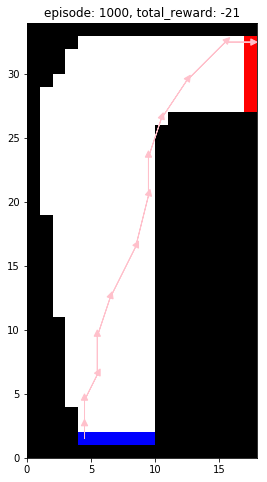

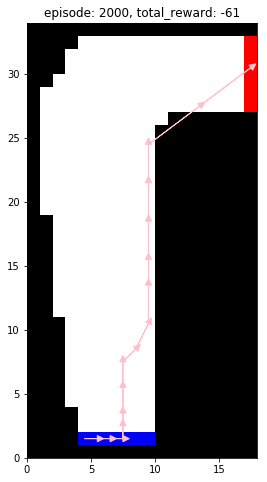

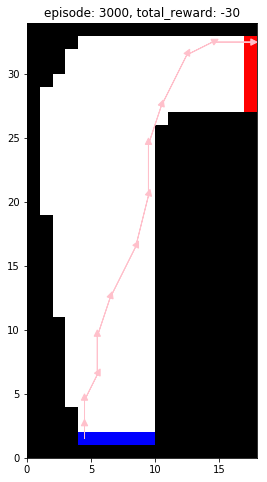

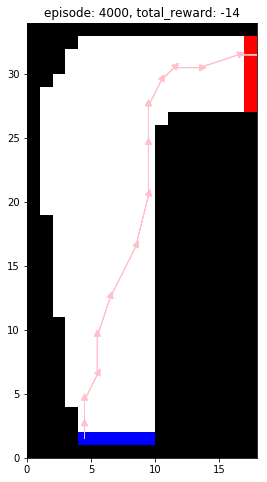

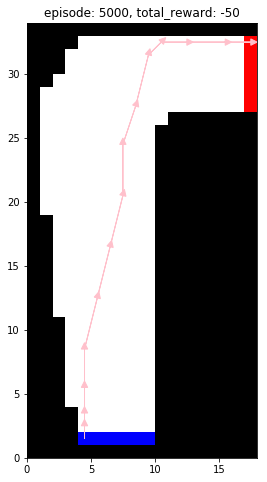

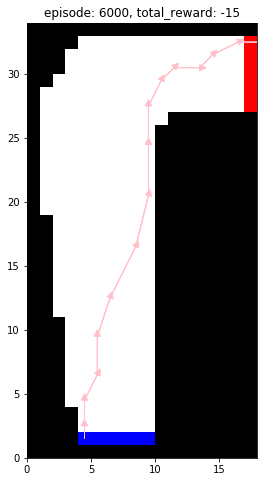

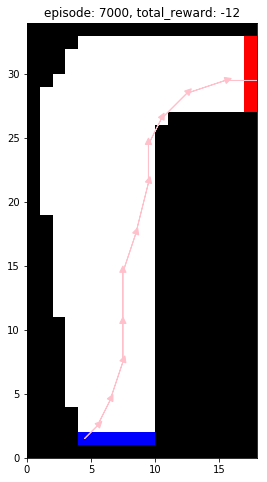

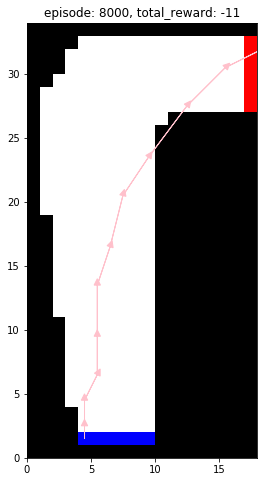

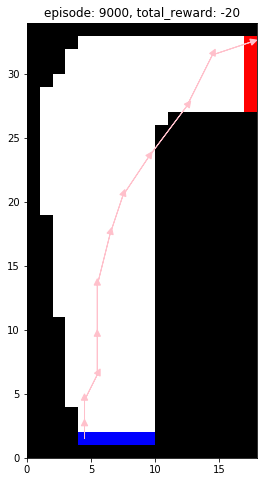

In [13]:
def callback(environment, state_action_rewards, episode_iter, total_reward):    
    if episode_iter % 1000 == 0:
        draw_path(environment, state_action_rewards, 'episode: {:d}, total_reward: {}'.format(episode_iter, 
                                                                                              total_reward))
last_state_action_rewards, total_reward_list = mccontrol1.learn((4,1,0,0), track1, episode_num=10000,
                                                                episode_end_callback=callback)

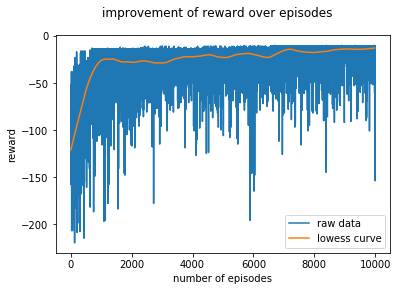

In [14]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# python implementation 
xs = list(range(0, len(total_reward_list), 20))
shorter_list = [total_reward_list[idx] for idx in xs]
ys = lowess(shorter_list, xs, frac=0.1)[:,1]
plt.plot(total_reward_list, label='raw data')
plt.plot(xs, ys, label='lowess curve')
plt.xlabel('number of episodes')
plt.ylabel('reward')
plt.suptitle('improvement of reward over episodes')
plt.legend()
plt.show()

In [15]:
trackstr2 = """
000000000000000000000000000000000
000000000000000001111111111111112
000000000000001111111111111111112
000000000000011111111111111111112
000000000000111111111111111111112
000000000000111111111111111111112
000000000000111111111111111111112
000000000000111111111111111111112
000000000000011111111111111111112
000000000000001111111111111111112
000000000000000111111111111111100
000000000000000111111111111100000
000000000000000111111111111000000
000000000000000111111111100000000
000000000000000111111111000000000
000000000000001111111111000000000
000000000000011111111111000000000
000000000000111111111111000000000
000000000001111111111111000000000
000000000011111111111111000000000
000000000111111111111111000000000
000000001111111111111111000000000
000000011111111111111111000000000
000000111111111111111111000000000
000001111111111111111111000000000
000011111111111111111111000000000
000111111111111111111111000000000
001111111111111111111111000000000
011111111111111111111111000000000
011111111111111111111111000000000
033333333333333333333333000000000
000000000000000000000000000000000
"""

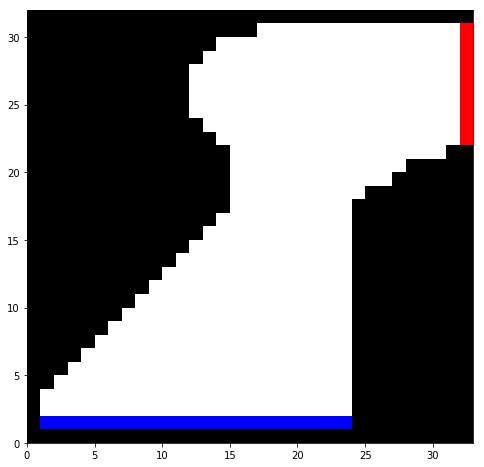

In [16]:
trackdata2 = trackstr_to_array(trackstr2)
draw_track(trackdata2)

In [17]:
np.where(trackdata2 == 3)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]))

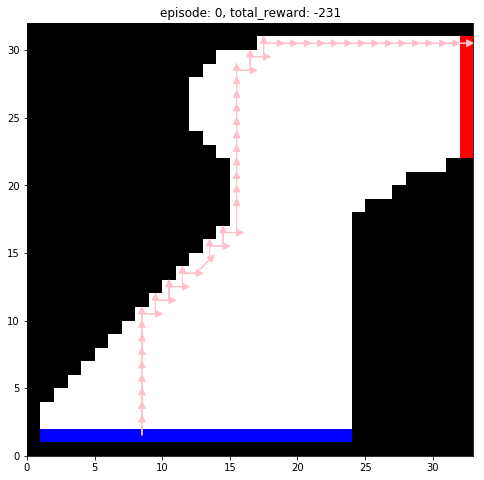

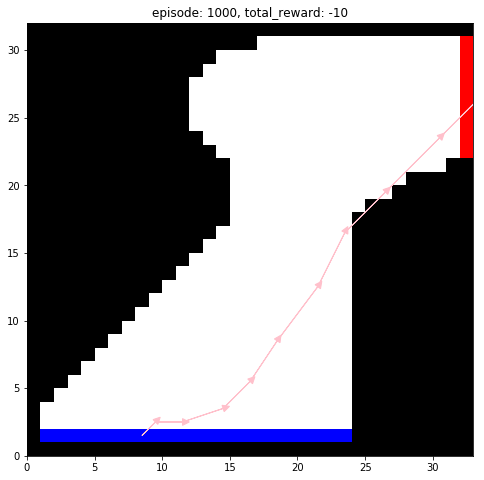

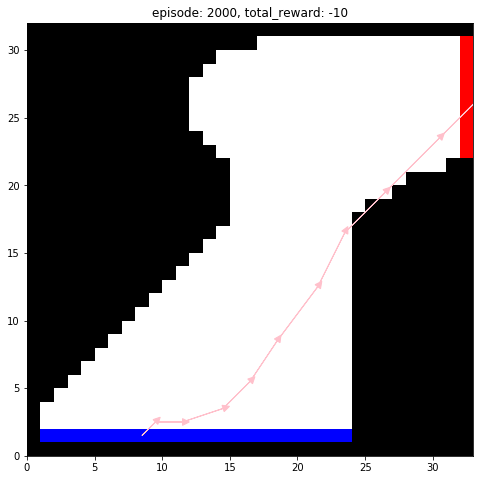

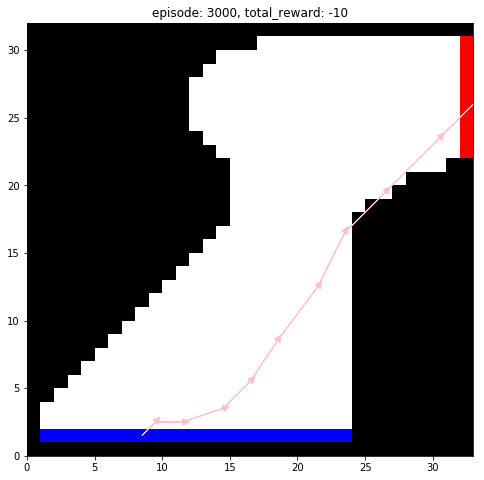

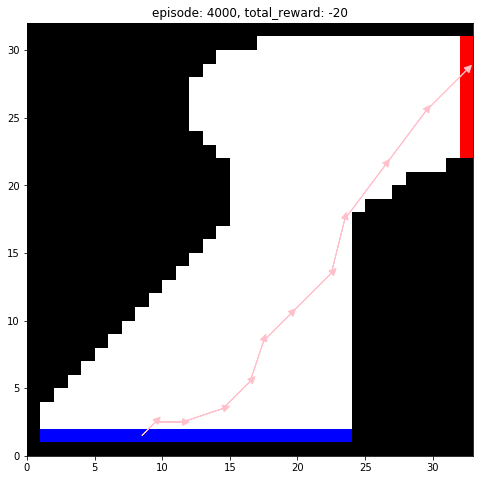

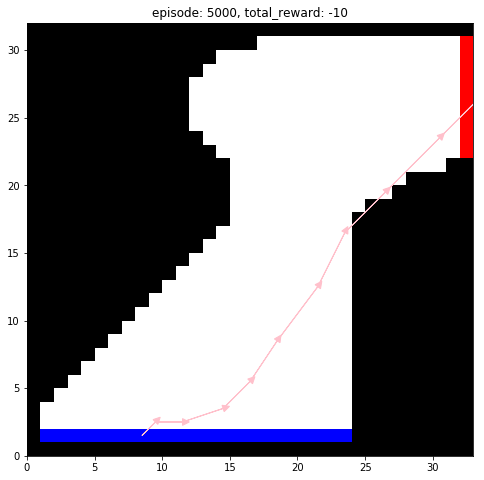

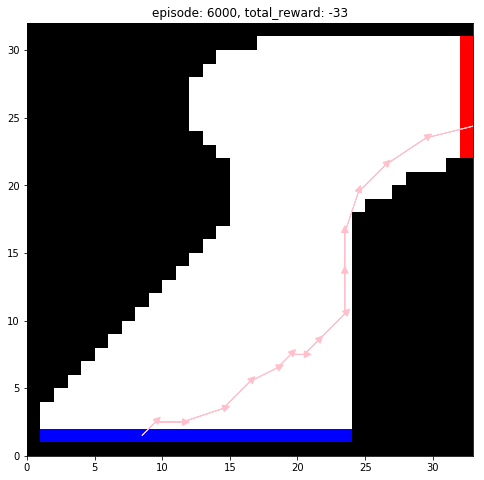

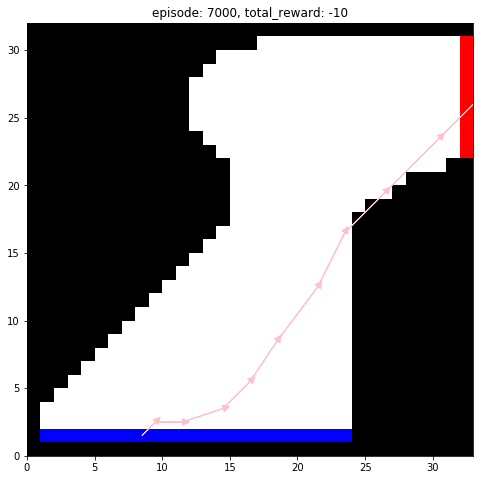

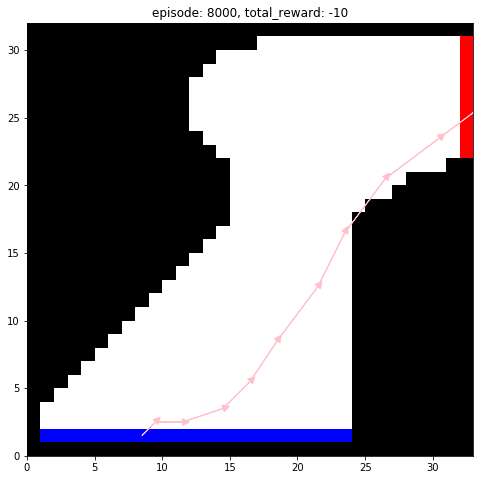

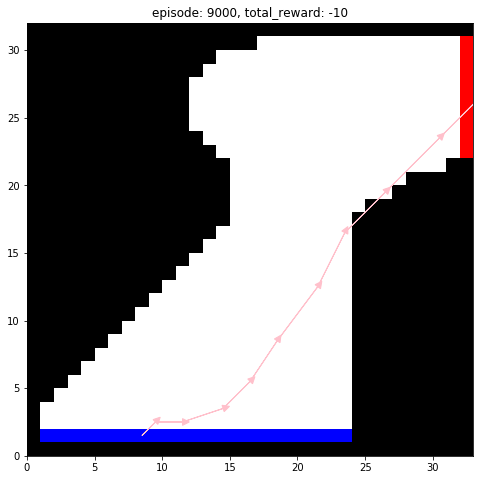

In [18]:
track2 = RaceTrack(trackdata2)
mccontrol2 = OnPolicyMonteCarloControl()
last_state_action_rewards, total_reward_list = mccontrol2.learn((8,1,0,0), track2, episode_num=10000,
                                                                episode_end_callback=callback)

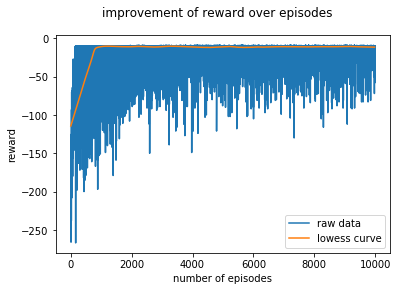

In [19]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# python implementation 
xs = list(range(0, len(total_reward_list), 20))
shorter_list = [total_reward_list[idx] for idx in xs]
ys = lowess(shorter_list, xs, frac=0.1)[:,1]
plt.plot(total_reward_list, label='raw data')
plt.plot(xs, ys, label='lowess curve')
plt.xlabel('number of episodes')
plt.ylabel('reward')
plt.suptitle('improvement of reward over episodes')
plt.legend()
plt.show()

## SARSA

Now, let us approach this problem with SARSA on-policy TD control (Section 6.4). 

In [20]:
class SARSA(object):
    
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=1.0):
        self.state_action_values = defaultdict(float)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
    
    def get_policy(self):
        def policy(state, action_set):
            if random.random() < self.epsilon:
                return random.choice(action_set)
            else:
                # find greedy action
                cand_action = None
                cand_value = float('-inf')                
                for action in action_set:
                    value = self.state_action_values[(state, action)]
                    if value > cand_value:
                        cand_action = action
                        cand_value = value
                return cand_action  
        return policy
    
    def learn(self, start_state, environment, episode_num=10, episode_end_callback=None, verbose=False):
        policy = self.get_policy()
        total_reward_list = []
        for episode_iter in range(episode_num):
            state = start_state
            total_reward = 0
            state_action_rewards = []
            if verbose:
                print('start_state: {}'.format(start_state))
                
            state = start_state
            action = policy(state, environment.actions(state))
            
            while True:                
                if verbose:
                    print('state: {}, action: {}'.format(state, action))                
                new_state, reward, is_terminal = environment.next(state, action)
                state_action_rewards.append((state, action, reward))
                new_action = policy(new_state, environment.actions(new_state))                
                gradient = (reward + 
                            self.gamma * self.state_action_values[(new_state, new_action)]
                            - (0 if is_terminal else self.state_action_values[(state, action)]))
                self.state_action_values[(state, action)] += self.alpha * gradient
                total_reward += reward
                
                state = new_state
                action = new_action
                
                if is_terminal:
                    state_action_rewards.append((new_state, None, 0))
                    break
                    
            if verbose:
                print('total reward: {}'.format(total_reward))
                        
            total_reward_list.append(total_reward)
            if episode_end_callback is not None:
                episode_end_callback(environment, state_action_rewards, episode_iter, total_reward)
                
        # return the last episode
        return state_action_rewards, total_reward_list

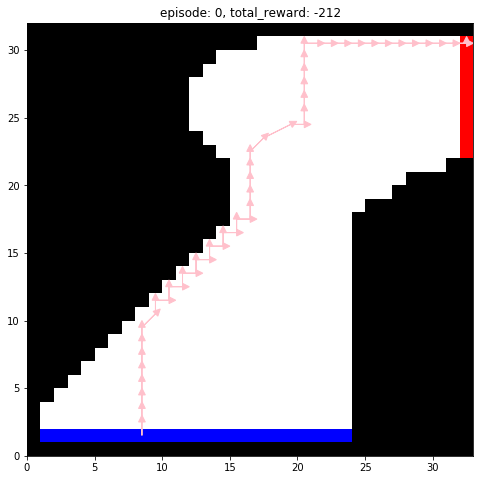

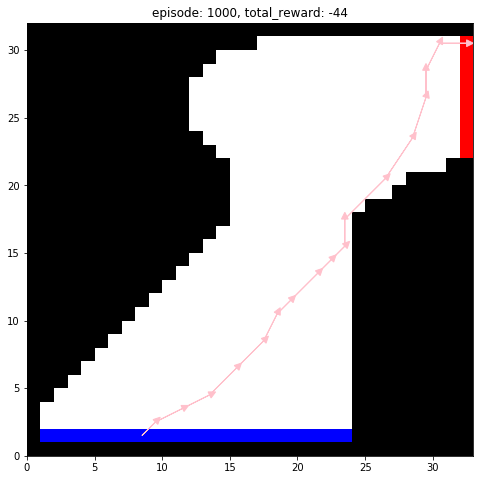

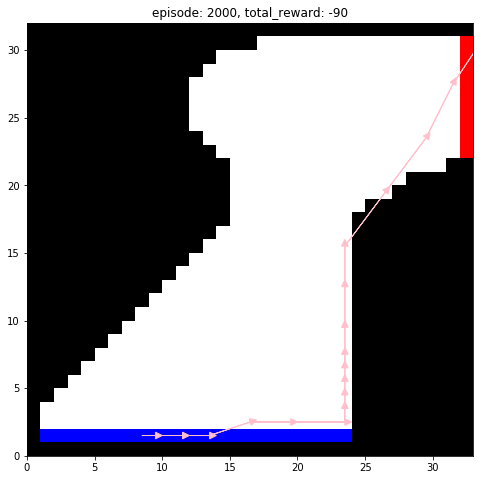

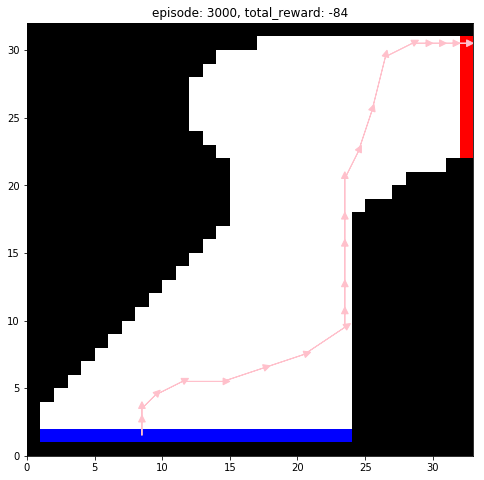

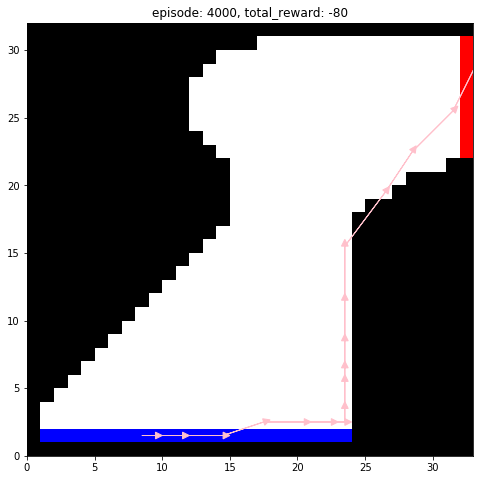

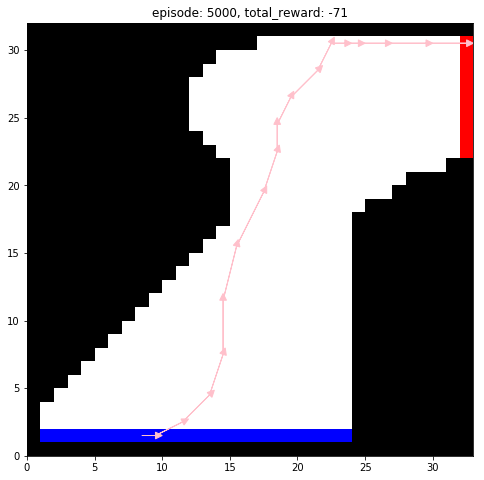

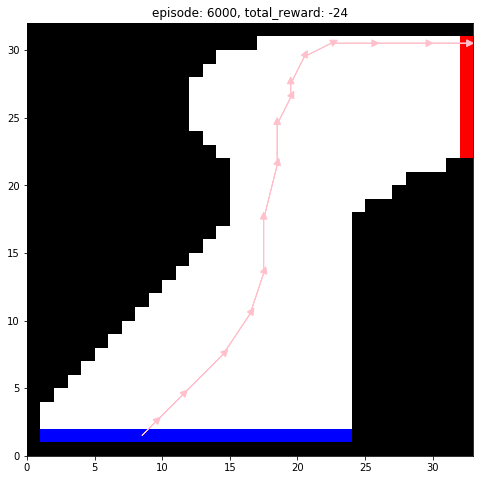

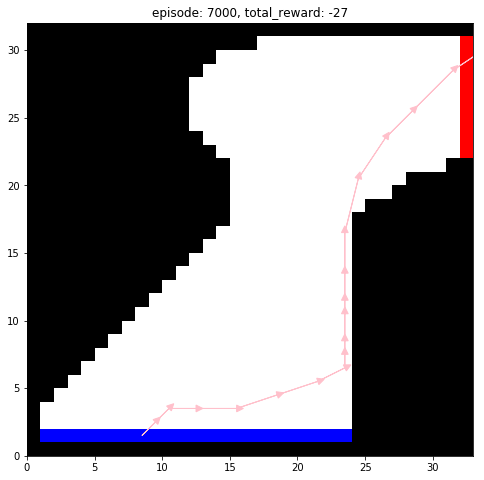

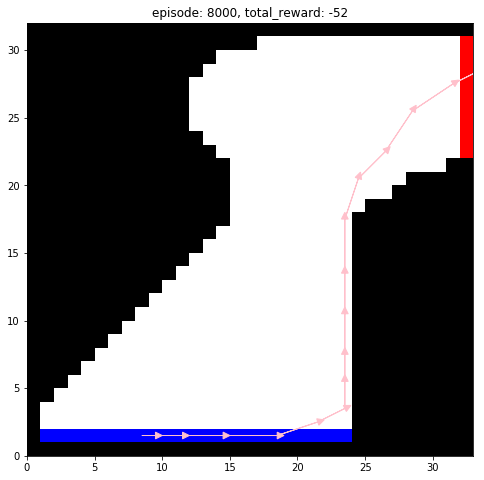

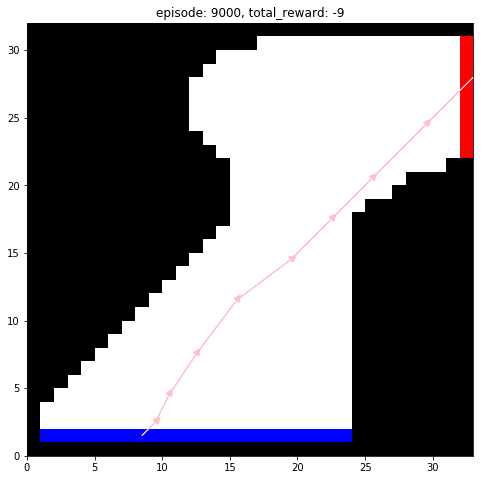

In [21]:
sarsa1 = SARSA()
_, total_reward_list_sarsa = sarsa1.learn((8,1,0,0), track2, episode_num=10000, episode_end_callback=callback)

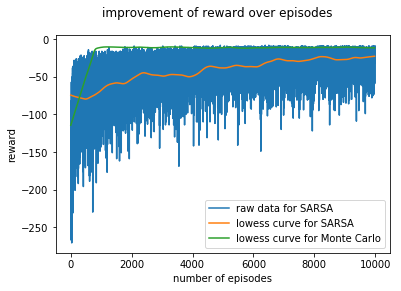

In [22]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# python implementation 
xs_sarsa = list(range(0, len(total_reward_list_sarsa), 20))
shorter_list_sarsa = [total_reward_list_sarsa[idx] for idx in xs]
ys_sarsa = lowess(shorter_list_sarsa, xs_sarsa, frac=0.1)[:,1]
plt.plot(total_reward_list_sarsa, label='raw data for SARSA')
plt.plot(xs_sarsa, ys_sarsa, label='lowess curve for SARSA')
plt.plot(xs, ys, label='lowess curve for Monte Carlo')
plt.xlabel('number of episodes')
plt.ylabel('reward')
plt.suptitle('improvement of reward over episodes')
plt.legend()
plt.show()

SARSA seems to converge a bit slower than Monte Carlo control, but I am not really sure why. Maybe each episode in this exercise is so short that data inefficiency of the Monte Carlo method does not matter too much, and the flexibility of the Monte Carlo method pays off? Or, maybe it's just hyperparameter tuning problem.